In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("asm_full_opt")
from phase_mask import PhaseMask
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
import config

sys.path.append("store_outputs/MNIST_7x7")
kernels = torch.load("store_outputs/MNIST_7x7/MNIST_8x7x7_kernels.pt")
sys.path.append("initial_phase")
from kernel_to_psf import Kernel2PSF

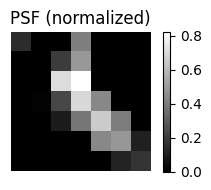

In [2]:
asm = ASMPropagator(config)

k2psf = Kernel2PSF(config)
raw_kernels = k2psf.split_kernels(kernels)

kernel0 = raw_kernels[0]

plt.figure(figsize=(3, 2))
plt.imshow((kernel0**1), cmap="gray")
plt.title("PSF (normalized)")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()

PSF size: torch.Size([255, 255])


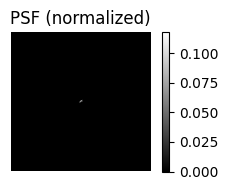

In [3]:
kernels_up1 = k2psf.upsample_and_center_kernels(raw_kernels, upsample=1)

kernel0_up1 = kernels_up1[0]
print("PSF size: " + str(kernel0_up1.shape))

plt.figure(figsize=(3, 2))
plt.imshow((kernel0_up1**1), cmap="gray")
plt.title("PSF (normalized)")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()

/var/folders/nb/4_pl8_150zg5d5snzc5tg0mm0000gn/T/ipykernel_46807/4119850991.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4419.)
  plt.imshow((psf0**1).T, origin="lower", cmap="viridis")


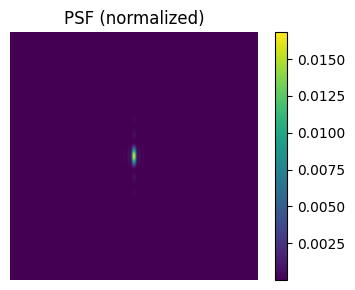

In [4]:
asm = ASMPropagator(config)

phase = PhaseMask(
    config,
    init="hyperbolic",
    X=asm.X,
    Y=asm.Y,    
    test_orientation=True,
)

with torch.no_grad():
    psf, Uz = asm(phase_mask=phase, normalize=True, return_field=True)

psf0 = psf.detach().cpu()

plt.figure(figsize=(4, 3))
plt.imshow((psf0**1).T, origin="lower", cmap="viridis")
plt.title("PSF (normalized)")
plt.colorbar()
plt.axis("off")
plt.tight_layout()
plt.show()

Loaded batch: torch.Size([10, 28, 28])
Labels: [3, 1, 1, 0, 4, 9, 2, 0, 0, 2]
Square shape: torch.Size([28, 28])


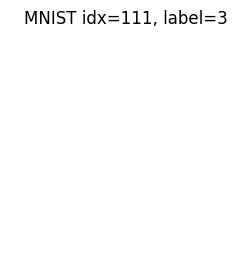

In [5]:
from torchvision.datasets import MNIST

# Load dataset
ds = MNIST(root="./data", train=True, download=False)

N_batch, idx0 = 10, 111

# Build batch
batch = [ds[idx0 + i] for i in range(N_batch)]
objs = torch.stack([
    torch.from_numpy(np.array(x)).float() / 255.0
    for x, _ in batch
])
labels = [y for _, y in batch]

print("Loaded batch:", objs.shape)
print("Labels:", labels)

square = torch.ones(28, 28)
print("Square shape:", square.shape)

# Show one image
plt.figure(figsize=(3,3))
plt.imshow(square, cmap="gray", vmin=0, vmax=1)
plt.title(f"MNIST idx={idx0}, label={labels[0]}")
plt.axis("off")
plt.show()


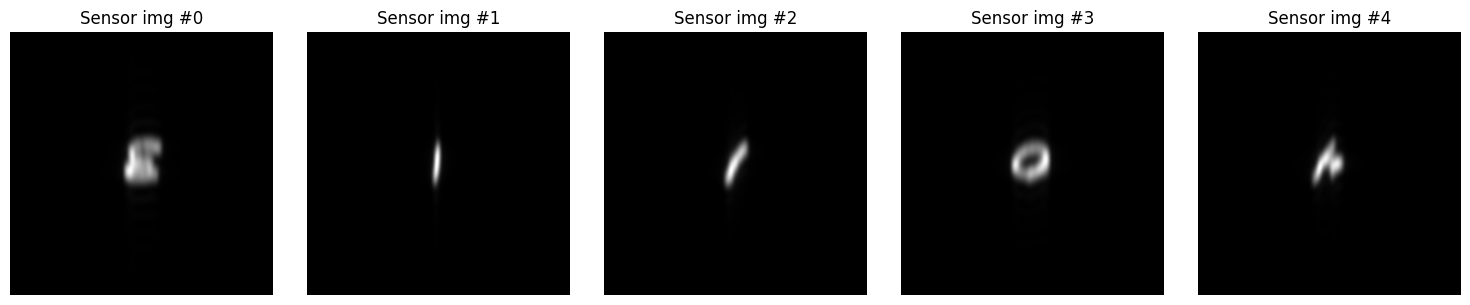

In [6]:
pm = PixelMap(config, asm.X, asm.Y)

conv = PSFConv(config, pm, asm.X, asm.Y)

imgs = conv.sensor_image(objs, psf)

num_show = min(5, imgs.shape[0])

fig, axs = plt.subplots(1, num_show, figsize=(3*num_show, 3))

for i in range(num_show):
    axs[i].imshow(
        imgs[i, 0].T.detach().cpu(),
        origin="lower",
        cmap="gray"
    )
    axs[i].set_title(f"Sensor img #{i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()